# Brownian-Langevin dynamic simulation

Run the cells




In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
import math

%matplotlib notebook

The multi-tau correlator class was adapted from the code by J. Ramírez https://doi.org/10.1063/1.3491098

In [2]:
class Correlator:
    """multi-tau correlator class
    
    tau's are contained within the variable t
    correlation contained within the variable f
    """
    def __init__(self, numcorrin, pin, mini):
        self.numcorrelators = numcorrin
        self.p = pin
        self.m = mini
        self.dmin = self.p/self.m
        
        self.length = self.numcorrelators*self.p
        
        self.shift = np.zeros((self.numcorrelators,self.p ))       
        self.correlation = np.zeros((self.numcorrelators,self.p )) 
        self.ncorrelation = np.zeros((self.numcorrelators,self.p )) 
        self.accumulator = np.zeros(self.numcorrelators)
        self.naccumulator = np.zeros(self.numcorrelators)
        self.insertindex = np.zeros(self.numcorrelators)        
               
        self.npcorr =0
        self.kmax=0
        self.accval=0
        
        self.one = np.ones(self.p) 
        self.t = np.concatenate((np.arange(self.p) ,(np.arange(self.dmin,self.p,1)*self.m**np.arange(1,self.numcorrelators,1)[:,np.newaxis]).ravel()))
        self.f = np.zeros(self.length)

    def addnumpy(self, w, k=0):
        "adds a new single value to the trace"
# 	 If we exceed the correlator side, the value is discarded
        if (k >= self.numcorrelators): 
            return None
        if (k > self.kmax): 
            self.kmax=k
        ind1 = int(self.insertindex[k])
# 	/// Insert new value in shift array
        self.shift[k][ind1] = w

# 	/// Add to average value
        if (k == 0):
            self.accval += w

# 	/// Add to accumulator and, if needed, add to next correlator    /// THIS SENDS THE DATA TO THE NEXT K, AVERAGING
        self.accumulator[k] += w
        self.naccumulator[k] += 1
        if (self.naccumulator[k]==self.m): 
            self.addnumpy(self.accumulator[k]/self.m, k+1)
            self.accumulator[k]=0
            self.naccumulator[k]=0
            

        self.correlation[k] += w*np.concatenate((self.shift[k][ind1::-1],self.shift[k][-1:ind1:-1]))
        self.ncorrelation[k] +=self.one#[self.correlation[0] !=  0] += self.one[self.correlation[0] !=  0] 
#         replace ncorrelation with a product at the end?

        self.insertindex[k]+=1
        if (self.insertindex[k]==self.p):
            self.insertindex[k] = 0 # ///first in first out 
            
            
    def evaluate(self,norm=False): 
        "calculates the correlation, does not return the correlation"
        aux = 0
        if (norm):
            aux = (self.accval/self.ncorrelation[0][0])*(self.accval/self.ncorrelation[0][0])

        self.f[:int(self.p)] = self.correlation[0]/self.ncorrelation[0] - aux
        self.f[int(self.p):int(self.p) + int(self.kmax*self.dmin)] = (self.correlation[1:int(self.kmax+1),int(self.dmin):] / self.ncorrelation[1:int(self.kmax+1),int(self.dmin):] - aux).ravel()

        self.npcorr = int(self.p) + self.kmax*self.dmin


In [3]:
def zProb(R,zbox=40.0, l=0.0):
    "returns a particle z location at random according to a potential"
    #     SURFACE POTENTIAL
    f = lambda x,x2: np.exp(-np.exp(l*(x-x2)))
    new=np.ndarray(R.size)
    for i in np.arange(R.size):
        denied = True
        while denied:
            rnd1 = np.random.ranf()
            z = (rnd1*(zbox-R[i]))+ R[i]
            if np.random.ranf()*1.05 < f(z,R[i]):
                denied = False
                new[i] = z
    return new

def shearVel(z, sr = 0.0, vs = 0.0):
    """gives the velocity according to the imposed flow"""
    return sr*z + vs    

def xSlow(z,R=1.0):
    """
    xSlow multiplies the velocity
    """
    return 1.0-5/16.0/(z*z*z)*R*R*R

def DxSlow(z,R=1.0): 
    """
    diffusion slowdown along wall
    D=D0*slowdown
    """
    return 1.0-9.0/16.0*R/z + 1/8.0*R*R*R/(z*z*z) - 45/256.0*R*R*R*R/(z*z*z*z) - 1/16.0*R*R*R*R*R/(z*z*z*z*z)

def DzSlow(z , R=1.0 ):
    """
    diffusion slowdown normal to wall
    """
    return (6.0*(z/R-1.0)*(z/R-1.0) + 2.0*(z/R-1.0)) / (6.0*(z/R-1.0)*(z/R-1.0) + 9.0*(z/R-1) + 2.0 )


def masterMotion(x,z,R,D,rate,slip=0.0,xBox=100.0,zBox=40.0,dt=1.0,ld=0.0):
    """
    equations of motion in 2D, including boundary conditions
    """
    if D==0:
        x +=   xSlow(z,R)*shearVel(z,sr=rate,vs=slip)*dt     
    else:
        x += np.random.normal(scale=np.sqrt(2.0*D*dt*DxSlow(z,R)),size=len(x)) + xSlow(z,R)*shearVel(z,sr=rate,vs=slip)*dt   
        z += np.random.normal(scale=np.sqrt(2.0*D*dt*DzSlow(z,R)), size=len(x)) + D*DriftDz(z,R)*dt + dt*dt*wallForce(z,R,ld)
    
    x[x < 0] += xBox
    x[x > xBox] -= xBox
    z[z < R] -= R[z < R]*2.0
    z[z < R] *= -1.0
    
    z[z > zBox] = zBox*2.0 - z[z > zBox]
    

def DriftDz(z, R=1.0 ): 
    """correction term due the presence of the wall """
    return ( 22.0 -60.0*z/R + 42.0*z*z/R/R) /((1.0+ 3.0*z/R -6.0*z*z/R/R)*(1.0+ 3.0*z/R -6.0*z*z/R/R))


# this wall force term was set to 1 to avoid integration errors
# no force is exerted onthe particles
def wallForce(z,r=1.0, l=0.0):
    return -l*np.exp(l*(z-r))
            
def EW(z,r=1.0,dp=2.0):
    """
    intensity of scattered field according to the EW distribution
    """
    return r*r*r*np.exp(-z/dp)

In [4]:
class Simulation:
    
    def __init__(self,n=100, steps= 0,D=0.005 ,rate=0.001, v0=0.0,zBox=40.0, xBox=100.0, dt=1.0, R=1.0, dp=2, angle=90,l=1.0, ld=0.0, polydispersity = 0.1):
        self.ld = ld
        self.dp = dp
        self.dp *= R
        l *= R 
        k0 = 2*np.pi/l
        q = np.array([k0*(np.cos(np.pi/180.0*angle)-1), k0*np.sin(np.pi/180.0*angle)])
        self.q = q
        xBox *= R
        self.xBox = xBox
        zBox *= R
        self.zBox = zBox
        self.R = R
        self.dt=dt
        self.inten = np.array([0.0+1j*0.0])
        self.v0 = v0
        self.D = D
        self.rate = rate
        nsteps = steps
        self.nParticles = n
        self.polydispersity = polydispersity
        
        self.coscorr = Correlator(32,32,2)
        self.sincorr = Correlator(32,32,2)
        
        self.result = np.array([])
        
        self.repetition = 10000
        self.counter = 0
        self.newparticles()
        
        for i in np.arange(nsteps):
            self.step()
            
    def newparticles(self):
        "creates a new set of particles"
        self.particles = np.ones((self.nParticles,2))
        self.particles[:,0] *= np.random.ranf(self.nParticles)*self.xBox
        self.polyR = np.random.normal(scale=self.R*self.polydispersity, size=self.nParticles) + self.R
        self.particles[:,1] = zProb(self.polyR,self.zBox, self.ld)
            
    def step(self):
        "moves all of the particles one step"
        masterMotion(self.particles[:,0],self.particles[:,1],R=self.polyR, D=self.D, rate=self.rate,slip= self.v0, xBox=self.xBox,zBox=self.zBox, dt=self.dt, ld = self.ld)

        self.inten = np.sum( EW(self.particles[:,1],self.polyR, self.dp)*np.exp(1j* np.dot(self.particles, self.q ) ))  #single sum, speed twice
             
        self.coscorr.addnumpy(self.inten.real)
        self.sincorr.addnumpy(self.inten.imag)  
        
        self.counter += 1
        if (self.counter > self.repetition):
            self.counter = 0
            self.newparticles()
        
    
    def evaluate(self):
        "recovers the correlations and returns tau's and the correlation"
        self.coscorr.evaluate(norm=True)
        self.sincorr.evaluate(norm=True) 
        
        
        self.result = (self.coscorr.f[0:int(self.coscorr.npcorr)] + self.sincorr.f[0:int(self.sincorr.npcorr)])/self.nParticles

        return self.coscorr.t[0:int(self.coscorr.npcorr)]*self.dt, self.result #,self.result2

Create two instances for the demos. 
 * one for shear flow
 * one for diffusion
 
You can tweak the parameters here to play with the output.

The last two cells will show the live simulation in a new window.

In [54]:
# instance of flow and diffusion simulation

sim = Simulation(500,1000,D=0.0001,rate=0.01,v0=0., xBox=100.0 , zBox=20.0,R=1.0,dt=0.5,ld=0, angle=90,dp=2, polydispersity=0.0)
simD = Simulation(500,1000,D=0.0001,rate=0.0,v0=0., xBox=100.0 , zBox=20.0,R=1.0,dt=5,ld=0, angle=90,dp=2, polydispersity=0.0)

## Diffusion

<IPython.core.display.Javascript object>


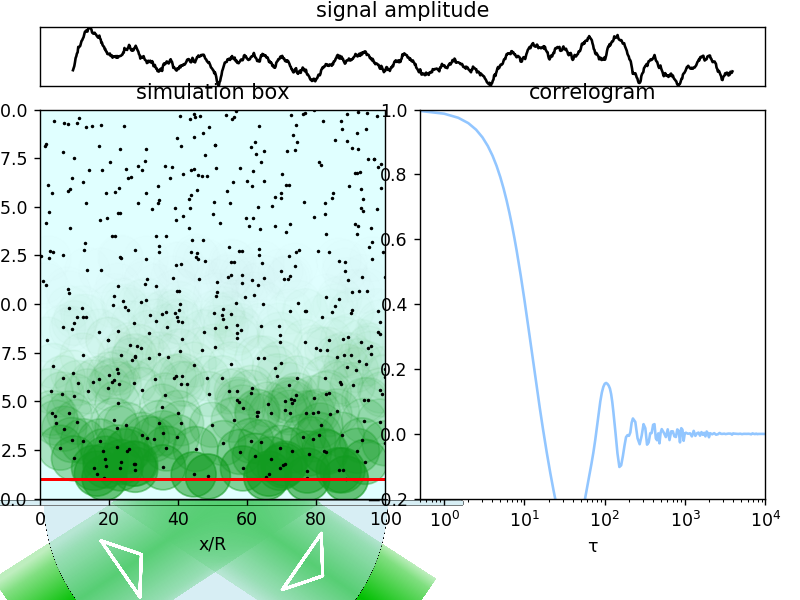

In [58]:
# demonstration with intensity bar DIFFUSION
fig = plt.figure()

bint=plt.subplot2grid((7, 2), (0, 0), colspan=2)
bpar=plt.subplot2grid((7, 2), (1, 0),rowspan=5)
bcorr=plt.subplot2grid((7, 2), (1, 1),rowspan=5)

bint.axes.get_xaxis().set_visible(False)
bint.axes.get_yaxis().set_visible(False)
bint.set_title("signal amplitude")
trace=np.zeros(1000)
time=np.arange(0,1000)
intensity,=bint.plot(time,trace,c=[0,0,0,1])  

line = bpar.scatter([],[])
line2 =bpar.scatter([],[],s=0.1)


line3, = bcorr.semilogx([],[])
bcorr.set_ylim(-0.2, 1)
bcorr.set_xlim(sim.dt, 10000)

color=np.ones((len(simD.particles[:,0]),4))
color[:,0]=18/255.
color[:,1]=155/255.
color[:,2]=32/255.
bpar.set_ylim(0, sim.zBox)
bpar.set_xlim(0, sim.xBox)
bpar.set_facecolor([224/255.,255/255.,255/255.])


plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(top=0.955,left=0.05)

image = plt.imread('lens2.png',format='png')
lens = fig.add_axes([-0.231, -0.125, 1, 0.3],zorder=-1)
lens.imshow(image)
lens.axis('off')
bcorr.set_title('correlogram')
bpar.set_title('simulation box')
bcorr.set_xlabel('τ')
bcorr.set_ylim(-0.2, 1)
bcorr.set_xlim(simD.dt, 10000)


simD.step()
line=bpar.scatter(simD.particles[:,0],simD.particles[:,1],s=670)   
line2=bpar.scatter(simD.particles[:,0],simD.particles[:,1],s=1,c=[[0,0,0]])
color[:,3]=np.exp(-simD.particles[:,1]/sim.dp)
line.set_color(color)

times = 50
global counter
counter=0
def update(i):
    global counter
#     counter=0
    
    for j in np.arange(times):
        simD.step()
        trace[counter]=np.abs(simD.inten)
        counter+=1
        if counter==1000:
            counter=0
    bpar.set_ylabel('z/R')
    bpar.set_xlabel('x/R')
    
    bpar.set_ylim(0, simD.zBox)
    bpar.set_xlim(0, simD.xBox)
    line.set_offsets(simD.particles)   
    line2.set_offsets(simD.particles)
    
    color[:,3]=np.exp(-simD.particles[:,1]/sim.dp)
    line.set_color(color)
    
    bpar.plot([0,simD.xBox],[1, 1],c=[1,0,0,1])  
    rest, resf = simD.evaluate()
    
    line3.set_data(rest, resf/resf[0])
    
    intensity.set_data(time,trace)
    bint.set_ylim(min(trace),max(trace)) 
    
    return line,line2,line3,intensity,


anim = animation.FuncAnimation(fig, update, interval=100, blit=True)

# plt.show()

## Shear flow

<IPython.core.display.Javascript object>


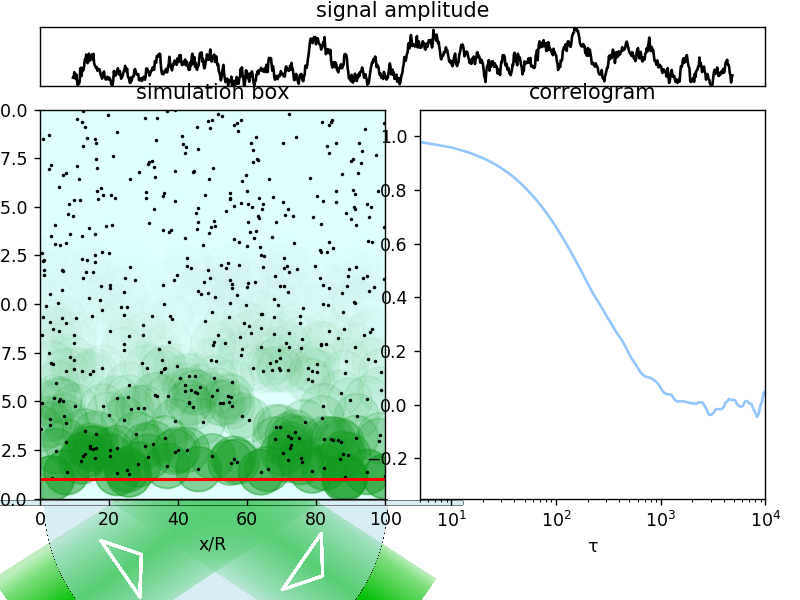

In [61]:
# demonstration with intensity bar FLOW
plt.rcParams['toolbar'] = 'None'

fig = plt.figure()

bint=plt.subplot2grid((7, 2), (0, 0), colspan=2)
bpar=plt.subplot2grid((7, 2), (1, 0),rowspan=5)
bcorr=plt.subplot2grid((7, 2), (1, 1),rowspan=5)

bint.axes.get_xaxis().set_visible(False)
bint.axes.get_yaxis().set_visible(False)
bint.set_title("signal amplitude")
trace=np.zeros(1000)
time=np.arange(0,1000)
intensity,=bint.plot(time,trace,c=[0,0,0,1])  

# bcorr.
line=bpar.scatter(sim.particles[:,0],sim.particles[:,1],s=670)   
line2=bpar.scatter(sim.particles[:,0],sim.particles[:,1],s=1,c=[[0,0,0]])
color[:,3]=np.exp(-sim.particles[:,1]/sim.dp)
line.set_color(color)


line3, = bcorr.semilogx([],[])
bcorr.set_ylim(-0.2, 1)
bcorr.set_xlim(sim.dt, 10000)

color=np.ones((len(sim.particles[:,0]),4))
color[:,0]=18/255.
color[:,1]=155/255.
color[:,2]=32/255.
bpar.set_ylim(0, sim.zBox)
bpar.set_xlim(0, sim.xBox)
bpar.set_facecolor([224/255.,255/255.,255/255.])

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(top=0.955,left=0.05)

image = plt.imread('lens2.png',format='png')
lens = fig.add_axes([-0.231, -0.125, 1, 0.3],zorder=-1)
lens.imshow(image)
lens.axis('off')
bcorr.set_title('correlogram')
bpar.set_title('simulation box')
bcorr.set_xlabel('τ')
bcorr.set_ylim(-0.35, 1.1)
bcorr.set_xlim(sim.dt, 10000)


times = 50
global counter
counter=0
def update(i):
    global counter
    
    for j in np.arange(times):
        sim.step()
        trace[counter]=np.abs(sim.inten)
        counter+=1
        if counter==1000:
            counter=0
    bpar.set_ylabel('z/R')
    bpar.set_xlabel('x/R')
    
    bpar.set_ylim(0, sim.zBox)
    bpar.set_xlim(0, sim.xBox)
    line.set_offsets(sim.particles)   
    line2.set_offsets(sim.particles)
    color[:,3]=np.exp(-sim.particles[:,1]/sim.dp)
    line.set_color(color)
    bpar.plot([0,sim.xBox],[1, 1],c=[1,0,0,1])  
    rest, resf = sim.evaluate()
    
    line3.set_data(rest, resf/resf[0])
    
    
    intensity.set_data(time,trace)
    bint.set_ylim(min(trace),max(trace))
    
    
    return line,line2,line3,intensity,

anim = animation.FuncAnimation(fig, update, interval=50, blit=True)

# plt.show()